## 4.3 欠陥画素補正

### この節について

この節では、欠陥画素補正を解説します。

この節のの内容はColabノートブックとして公開してあります。ノートブックを見るには[目次ページ](http://bit.ly/raw_toc)から参照するか、以下のリンクを使ってアクセスしてください。

http://bit.ly/raw_chap_4_3

### 準備

まずライブラリーのインストールと、モジュールのインポート、画像の読み込みを行います。今回もラズベリーパイで撮影したチャート画像を使用します。
内容については各節を参照ください。

In [1]:
# rawpyとimageioのインストール
!pip install rawpy;
!pip install imageio;

# rawpy, imageio, numpuy, pyplot, imshowのインポート
import rawpy, imageio
import numpy as np
import matplotlib.pyplot as plt

# 前節までに作成したモジュールのダウンロード
!if [ ! -f raw_process.py ]; then wget https://github.com/moizumi99/camera_raw_processing/raw/master/raw_process.py; fi

from raw_process import simple_demosaic, white_balance, black_level_correction, gamma_correction, demosaic

# 日本語フォントの設定
!apt -y install fonts-ipafont-gothic
plt.rcParams['font.family'] = 'IPAPGothic'

# 画像をダウンロードします。
!if [ ! -f chart.jpg ]; then wget https://github.com/moizumi99/camera_raw_processing/raw/master/chart.jpg; fi

# 自分で撮影した画像を使用する場合は以下のコメントを取り除きアップロードします。
# from google.colab import files
# uploaded = files.upload()

# RAWファイルの名前。
# アップロードしたファイルを使う場合はその名前に変更。
raw_file  = "chart.jpg"
raw = rawpy.imread(raw_file)
raw_array = raw.raw_image
h, w = raw_array.shape

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-18ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


In [0]:
# もし日本語が文字化けしている場合以下の３行の行頭の#を削除して実行後、
# import matplotlib
# target_dir = matplotlib.get_cachedir()
# ! rm {target_dir}/*.json
# その後Runtime->Restart Runtime選択してページ全体を再実行

### 欠陥画素

ライブラリーを使って対象画像の左下の方、グレイチャートの一部（図の赤でかこった部分）を現像して拡大表示すると、こんな部分があります。

In [0]:
# raw_processからインポートしたblack_level_correction関数を使用してブラックレベル補正。
blc_raw = black_level_correction(raw_array, raw.black_level_per_channel, raw.raw_pattern)
# raw_processからインポートしたwhite_balance()関数を使って、ホワイトバランス調整。
wb_raw = white_balance(blc_raw, raw.camera_whitebalance, raw.raw_colors)
# raw_processからインポートしたsimple_demosaic()関数を使って、簡易デモザイク処理。
dms_img = demosaic(wb_raw, raw.raw_colors)
# ラズベリーパイのRAW画像は10bitなので、1024で正規化しておく。
white_level = 1024.0
dms_img = dms_img / white_level
# raw_processからインポートしたgamma_crrection()関数を使って、ガンマ補正。
gmm_img = gamma_correction(dms_img, 2.2)

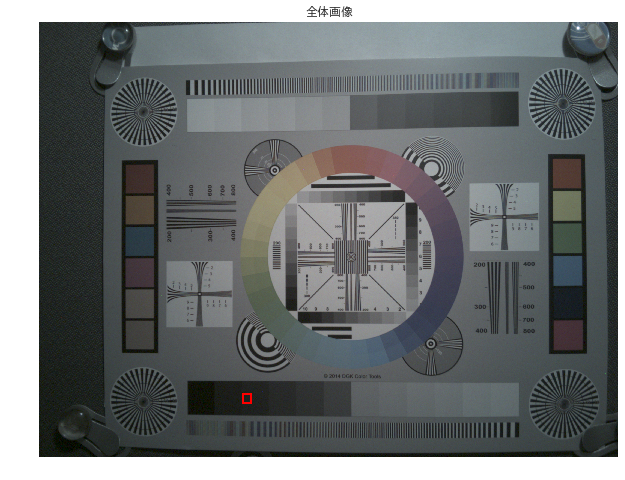

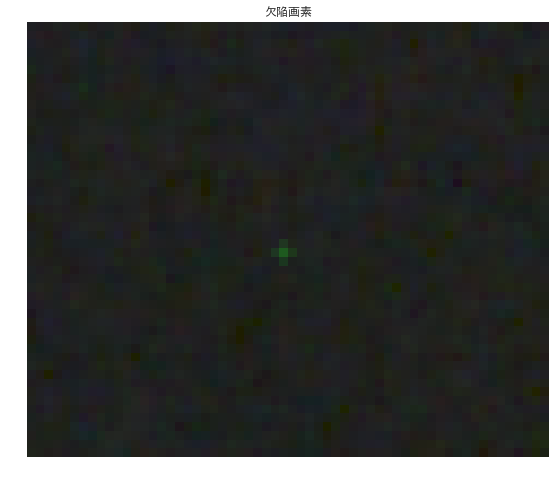

In [4]:
# 画像を表示。
plt.figure(figsize=(16, 8))
plt.imshow(gmm_img)
# 欠陥のある部分を示す赤い四角を描画。
# x=2210, y=1150から50x50の正方形を、塗りつぶしなし、赤色、線の太さ2で作成。
box = plt.Rectangle((1150, 2110), 50, 50, fill=False, edgecolor='red', linewidth=2)
# Pyplotのgca()を使ってAxesインスタンス（描画用の軸インスタンス）を取得。
# そのAxesインスタンスに先程のBoxをadd_patchを使って追加。
plt.gca().add_patch(box)
plt.axis('off')
plt.title(u"全体画像")
plt.show()

# 画像の一部分を拡大表示。
plt.figure(figsize=(16, 8))
plt.imshow(gmm_img[2110:2160, 1150:1210, :])
plt.axis('off')
plt.title(u"欠陥画素")
plt.show()

これはいわゆる欠陥画素です。 「欠陥」という名前がついていますが、製品の欠陥ではなく、一部の画素が正常な値を出力しない状態です。 多くの場合このように、常に明るく見えますが（ホットピクセル）、常に暗い（デッドピクセルまたはコールドピクセル）こともあれば、本来の信号とずれた値を示すという捕まえにくいケースもあります。

数ミリ角のサイズに数百万から数千万の画素を作り込む現代の画像センサーでは、一部にこのような欠陥画素が含まれていることはごく普通のことです。

なぜこのような欠陥ができるかというのには、さまざまな原因が考えられます。 たとえば製造過程でパーティクルが入り1特定の画素が反応しなくなったとか逆にショートして常に電流が流れるようになった、というのがまっさきに思いつきます。 まだ半導体中の結晶欠陥などのせいで基板側に電流が漏れている（または基板から漏れて入ってくる）のかもしれません。 さらには宇宙線などが当たって製造後に欠陥が形成されるケースもあると聞きます。

このように、画像センサーに欠陥画素はつきもので、画像処理である程度対応していく必用があります。 市販のスマートフォンのカメラはもちろん、一眼レフカメラなどでも欠陥画素補正処理は内部的に行われているはずです。

それでは、実際に簡単な補正処理を行ってみます。

欠陥画素補正には大きく分けて２つのステップがあります2。

- 欠陥画素検出
- 欠陥画素修正

今回は、欠陥画素検出としては、周辺の画素の最大値よりある程度以上大きいか最小値よりある程度以上小さければ欠陥とみなす、という方針で行います。 また修正としては、欠陥画素の上下左右４画素の平均をとる事にします。

それでは処理してみましょう。ブラックレベル補正後のデータ`blc_raw`から処理をはじめます。

各色毎に欠陥画素の検出と修正を行います。なお、ここではGr (Redと同列のGreen)とGb (Blueと同列のGreen)を別の色として処理しています。
まず、左上の色（Blue）からです。処理しやすいようにBlueのみを抜き出します。

In [0]:
dpc_raw = blc_raw.copy()
single_channel = dpc_raw[::2, ::2]

周辺の5x5画素の最大値と最小値を求めます。

最大値最小値を求めるのにscipyのndfilerモジュールから、maximum_filterとminimum_filterを使います。

In [0]:
import scipy

# 5x5の行列を作る、全成分を１にする。
footprint = np.ones((5, 5))
# 中心の値のみを０にする。
footprint[2, 2] = 0
# 入力画像の各画素周辺５ｘ５の最大値をもとめて、画像と同じサイズのnumpy arrayとして保存。
local_max = scipy.ndimage.filters.maximum_filter(single_channel, footprint=footprint, mode='mirror')
# 入力画像の各画素周辺５ｘ５の最小値をもとめて、画像と同じサイズのnumpy arrayとして保存。
local_min = scipy.ndimage.filters.minimum_filter(single_channel, footprint=footprint, mode='mirror')

ここでfootprintによって、どの画素を最大値・最小値の計算の対象にするか決めることができます。

ここでは、5x5の行列を作り、中心の成分のみをゼロ、他は1としてfootprintを作成しました。

$$ footprint = \begin{bmatrix}
    1 & 1 & 1 & 1 & 1 \\
    1 & 1 & 1 & 1 & 1 \\
    1 & 1 & 0 & 1 & 1 \\
    1 & 1 & 1 & 1 & 1 \\
    1 & 1 & 1 & 1 & 1
\end{bmatrix} $$

これを使うことで、欠陥画素かどうか判定する対象を最大値最小値の計算から取り除くことができます。

この最大値と最小値を使って、欠陥画素判定を行います。 最大値や最小値との差がthreshold値より大きい場合欠陥画素とみなす事にします。

In [0]:
threshold = 16
mask = (single_channel < local_min - threshold) + (single_channel > local_max + threshold)

これで欠陥画素の位置がmaskにTrueとして記録されました。（欠陥画素以外はFalse）

それでは修正しましょう。

まず、欠陥画素の上下左右の画素の平均値を計算しておきます。

In [0]:
# 上下左右の平均値を取るフィルター。
flt = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]) / 4
# scipyの機能で上下左右画素の平均値をとり、結果をnumpy arrayとして保存。
average = scipy.signal.convolve2d(single_channel, flt, mode='same')

次に欠陥画素をこの平均値で置き換えます。

欠陥画素はmaskのうちTrueになっている部分です。

In [0]:
single_channel[mask] = average[mask]

これでBlue面の欠陥画素補正ができました。

他の色の欠陥も補正するためにループ化します。

In [0]:
# ブラックレベル補正後の画像をコピー。
dpc_raw = blc_raw.copy()
# footprintとして5x5のマスクを作成
# [[1 1 1 1 1]
#  [1 1 1 1 1]
#  [1 1 0 1 1]
#  [1 1 1 1 1]
#  [1 1 1 1 1]]
footprint = np.ones((5, 5))
footprint[2, 2] = 0

# 各カラーごとの処理。左上(0, 0)、左下(1, 0), 右上(0, 1), 右下(1, 1)
for (yo, xo) in ((0, 0), (1, 0), (0, 1), (1, 1)):
    # １カラーチャンネルを取り出す。
    single_channel = dpc_raw[yo::2, xo::2]
    # 上下左右の平均をとるフィルター
    flt = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]) / 4
    # 平均値をとった画像の作成
    average = scipy.signal.convolve2d(single_channel, flt, mode='same')
    # 周辺画像の最大値を求める。footprintにより、対象となる画素は含めない。
    local_max = scipy.ndimage.filters.maximum_filter(single_channel, footprint=footprint, mode='mirror')
    # 周辺画像の最小値を求める。footprintにより、対象となる画素は含めない。
    local_min = scipy.ndimage.filters.minimum_filter(single_channel, footprint=footprint, mode='mirror')
    # 中心画素が最大値よりthreshold分以上大きい、または最小値よりthreshold分以上小さければ欠陥とみなす。
    threshold = 16
    # 欠陥の位置をTrueとして保存。
    mask = (single_channel < local_min - threshold) + (single_channel > local_max + threshold)
    # 欠陥画素を平均値で置換。
    single_channel[mask] = average[mask]
    # single_channelはdpc_rawへの参照なので書き戻す必用がない

残りのホワイトバランス、デモザイク、ガンマ処理を行い、出力結果を確認します。

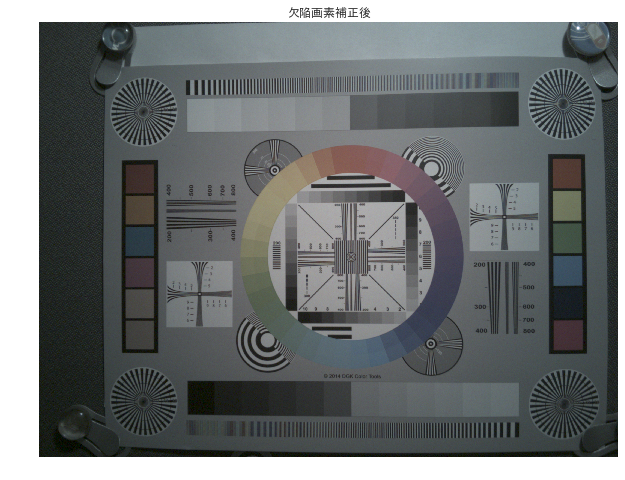

In [11]:
wb_raw = white_balance(dpc_raw, raw.camera_whitebalance, raw.raw_colors)
# raw_processからインポートしたsimple_demosaic()関数を使って、簡易デモザイク処理。
dms_img = demosaic(wb_raw, raw.raw_colors)
# ラズベリーパイのRAW画像は10bitなので、1024で正規化しておく。
white_level = 1024.0
dms_img = dms_img / white_level
# raw_processからインポートしたgamma_crrection()関数を使って、ガンマ補正。
gmm_img = gamma_correction(dms_img, 2.2)

# 画像の一部分を拡大表示。
plt.figure(figsize=(16, 8))
plt.imshow(gmm_img)
plt.axis('off')
plt.title(u"欠陥画素補正後")
plt.show()

欠陥画素が修正されたか、先ほどと同じ部分を拡大して確認しましょう。

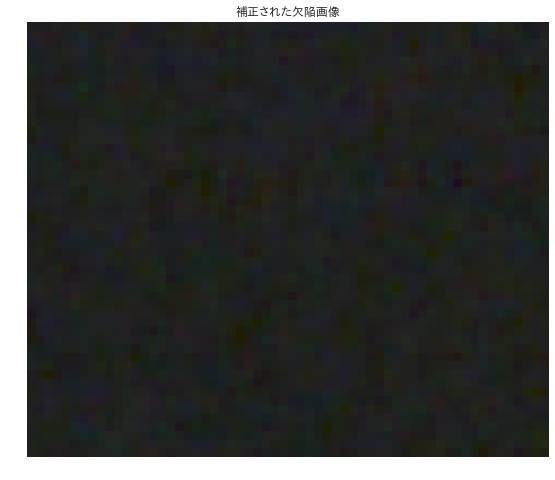

In [12]:
# 画像の一部分を拡大表示。
plt.figure(figsize=(16, 8))
plt.imshow(gmm_img[2110:2160, 1150:1210, :])
plt.axis('off')
plt.title(u"補正された欠陥画像")
plt.show()

どうやら修正されたようです。

### モジュールへの追加

この処理も関数としてモジュールへ追加しておきましょう。

In [0]:
def defect_correction(raw_array, threshold):
    """
    線形補間でデモザイクを行う

    Parameters
    ----------
    raw_array: numpy array
        入力BayerRAW画像データ。
    threshold: int
        欠陥画素判定の閾値。
        10bitRAW入力に対して典型的には16程度。

    Returns
    -------
    dpc_raw: numpy array
        出力RAW画像。
    """
    dpc_raw = raw_array.copy()
    # footprintとして5x5のマスクを作成
    # [[1 1 1 1 1]
    #  [1 1 1 1 1]
    #  [1 1 0 1 1]
    #  [1 1 1 1 1]
    #  [1 1 1 1 1]]
    footprint = np.ones((5, 5))
    footprint[2, 2] = 0
    # 各カラーごとの処理。左上(0, 0)、左下(1, 0), 右上(0, 1), 右下(1, 1)
    for (yo, xo) in ((0, 0), (1, 0), (0, 1), (1, 1)):
        single_channel = dpc_raw[yo::2, xo::2]
        # 上下左右の平均をとるフィルター
        flt = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]) / 4
        # 上下左右の平均値をとった画像の作成
        average = scipy.signal.convolve2d(single_channel, flt, mode='same')
        # 周辺画像の最大値を求める。footprintにより、対象となる画素は含めない。
        local_max = scipy.ndimage.filters.maximum_filter(single_channel, footprint=footprint, mode='mirror')
        # 周辺画像の最小値を求める。footprintにより、対象となる画素は含めない。
        local_min = scipy.ndimage.filters.minimum_filter(single_channel, footprint=footprint, mode='mirror')
        # 中心画素が最大値よりthreshold分以上大きい、または最小値よりthreshold分以上小さければ欠陥とみなす。
        # 欠陥の位置をTrueとして保存。
        mask = (single_channel < local_min - threshold) + (single_channel > local_max + threshold)
        # 欠陥画素を平均値で置換。
        single_channel[mask] = average[mask]
        # single_channelはdpc_rawへの参照なので書き戻す必用がない
    return dpc_raw

この`defect_correction()`関数は`raw_process.py`モジュールの一部として[githubにアップロード](https://raw.githubusercontent.com/moizumi99/raw_process/master/raw_process.py)されています。
使用する場合は、

`!wget https://raw.githubusercontent.com/moizumi99/raw_process/master/raw_process.py`

としてダウンロードした後、

`from raw_process import defect_correction`

としてインポートしてください。

### まとめ

この節では欠陥画素補正を行いました。次は[カラーマトリクス補正](http://bit.ly/raw_4_4)を行います。